# OSM Feature Extraction and Visualization for Bolívar

## Extract OSM Features

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import osmnx
import geopandas as gpd

In [ ]:
# Load Bolívar boundary
bolivar_gdf = gpd.read_file("data/boundaries/bolivar.geojson")
bolivar_geom = bolivar_gdf.union_all()

# Define OSM tags to extract
tags = {
    "highway": True,
    "waterway": True,
    "building": True,
    "landuse": True,
    "aeroway": True
}

# Fetch features from OSM using polygon boundary
osm_gdf = osmnx.features.features_from_polygon(bolivar_geom, tags=tags)

# Save features to GeoJSON
os.makedirs("data/contextual", exist_ok=True)
osm_gdf.to_file("data/contextual/osm_bolivar_features.geojson", driver="GeoJSON")

## Overview and Statistics

In [6]:
# Load the saved GeoJSON file
osm_gdf = gpd.read_file("data/contextual/osm_bolivar_features.geojson")

# Dataset summary
print(f"OSM features loaded: {len(osm_gdf)}")
print("\n--- OSM Feature Overview ---")
print(osm_gdf[["highway", "building", "landuse", "waterway", "aeroway"]].describe(include="all"))


/Users/selmadissing/miniforge3/envs/mining-detector/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: Several features with id = 313500437 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


OSM features loaded: 66980

--- OSM Feature Overview ---
            highway building      landuse waterway  aeroway
count         26250    23991         1444    14896      429
unique           34       44           24        9       10
top     residential      yes  residential    river  taxiway
freq          10210    19445          638    10381      143


## Feature Type Counts

/var/folders/z3/v5cktcqx18d9cgl3wk07wcrm0000gn/T/ipykernel_35174/726983565.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_counts_df.reset_index(), x="index", y="count", palette=color_map.values())


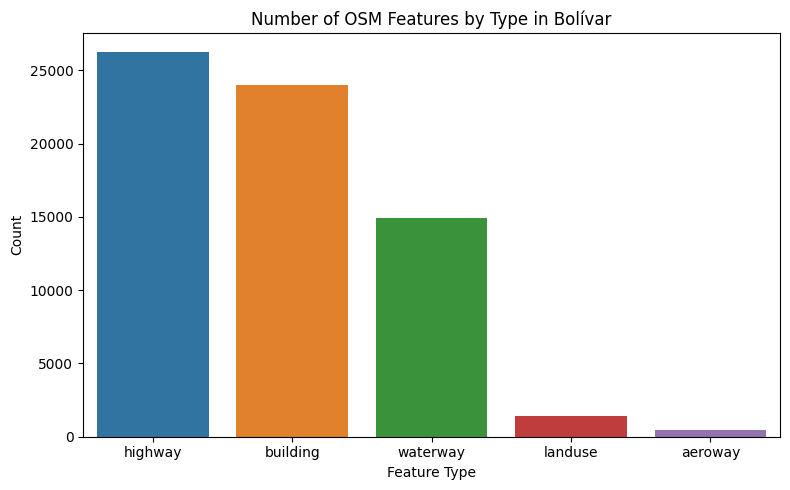

In [7]:
feature_tags = ["waterway", "highway", "landuse", "building", "aeroway"]

# Count non-null entries per feature type
feature_counts = {tag: osm_gdf[tag].notnull().sum() for tag in feature_tags}
feature_counts_df = pd.DataFrame.from_dict(feature_counts, orient="index", columns=["count"]).sort_values("count", ascending=False)

# Color map for plots
palette = sns.color_palette("tab10", n_colors=len(feature_tags))
color_map = dict(zip(feature_tags, palette))

# Bar plot
plt.figure(figsize=(8, 5))
sns.barplot(data=feature_counts_df.reset_index(), x="index", y="count", palette=color_map.values())
plt.title("Number of OSM Features by Type in Bolívar")
plt.xlabel("Feature Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Spatial Distribution of All OSM Features

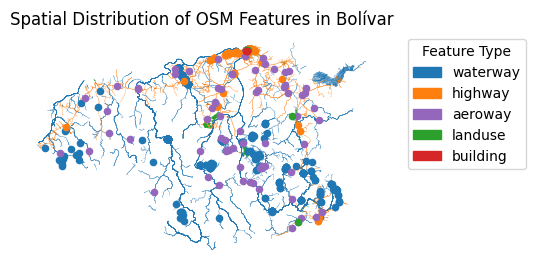

In [11]:
import matplotlib.patches as mpatches

# Assign dominant feature type column
osm_gdf['feature_type'] = osm_gdf[feature_tags].apply(
    lambda row: next((col for col in feature_tags if pd.notnull(row[col])), 'other'),
    axis=1
)

fig, ax = plt.subplots(figsize=(6, 6))

for feature_type in osm_gdf['feature_type'].unique():
    color = color_map.get(feature_type, "#999999")
    subset = osm_gdf[osm_gdf['feature_type'] == feature_type]

    if not subset.empty:
        # First plot Polygons and MultiPolygons
        polys = subset[subset.geometry.geom_type.isin(["Polygon", "MultiPolygon"])]
        if not polys.empty:
            polys.plot(ax=ax, color=color, linewidth=0.5, zorder=1)

        # Then plot Lines
        lines = subset[subset.geometry.geom_type == "LineString"]
        if not lines.empty:
            lines.plot(ax=ax, color=color, linewidth=0.2, zorder=2)

        # Finally plot Points on top
        points = subset[subset.geometry.geom_type == "Point"]
        if not points.empty:
            points.plot(ax=ax, color=color, markersize=20, zorder=3)

# Create legend handles based on feature_tags and color_map
legend_handles = [
    mpatches.Patch(color=color_map.get(ft, "#999999"), label=ft)  # use gray fallback
    for ft in osm_gdf['feature_type'].unique()
]

# Add custom legend
ax.legend(
    handles=legend_handles,
    title="Feature Type",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=10,
    frameon=True
)

plt.title("Spatial Distribution of OSM Features in Bolívar")
plt.axis('off')
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()


## Individual Feature Type Maps

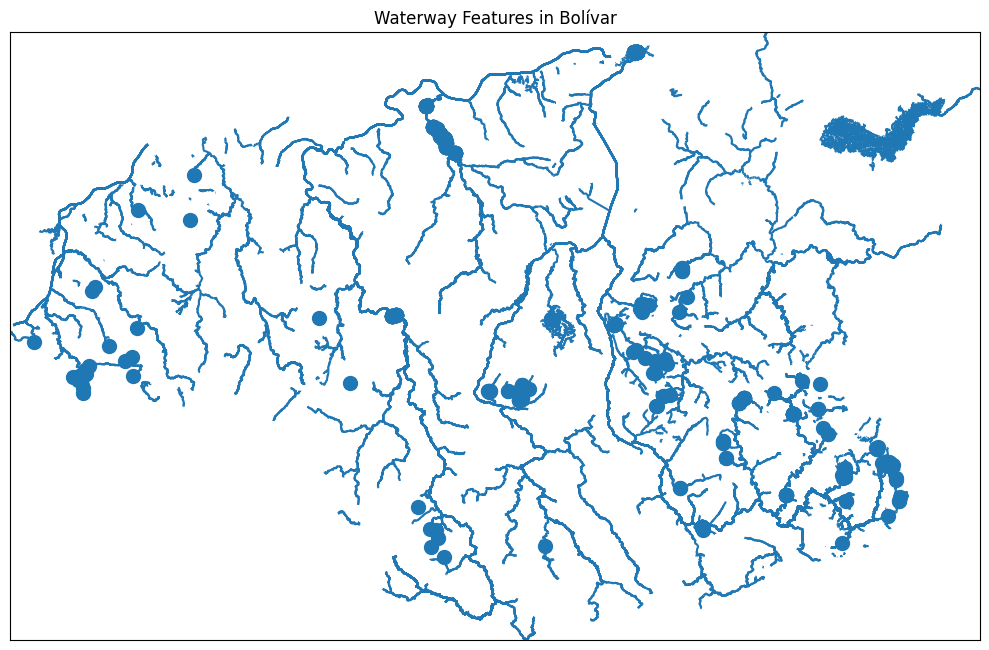

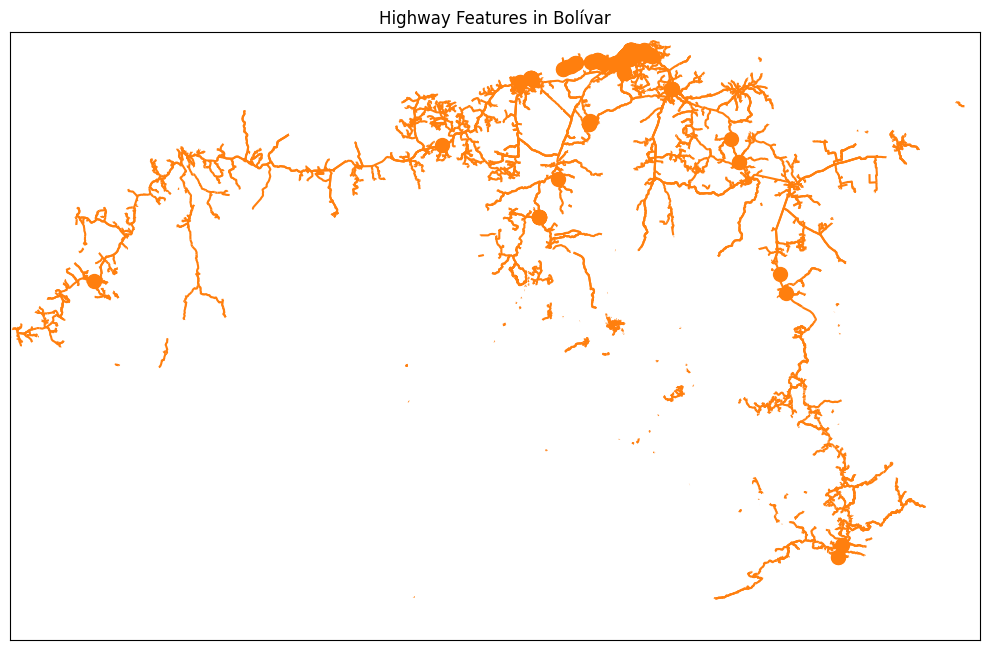

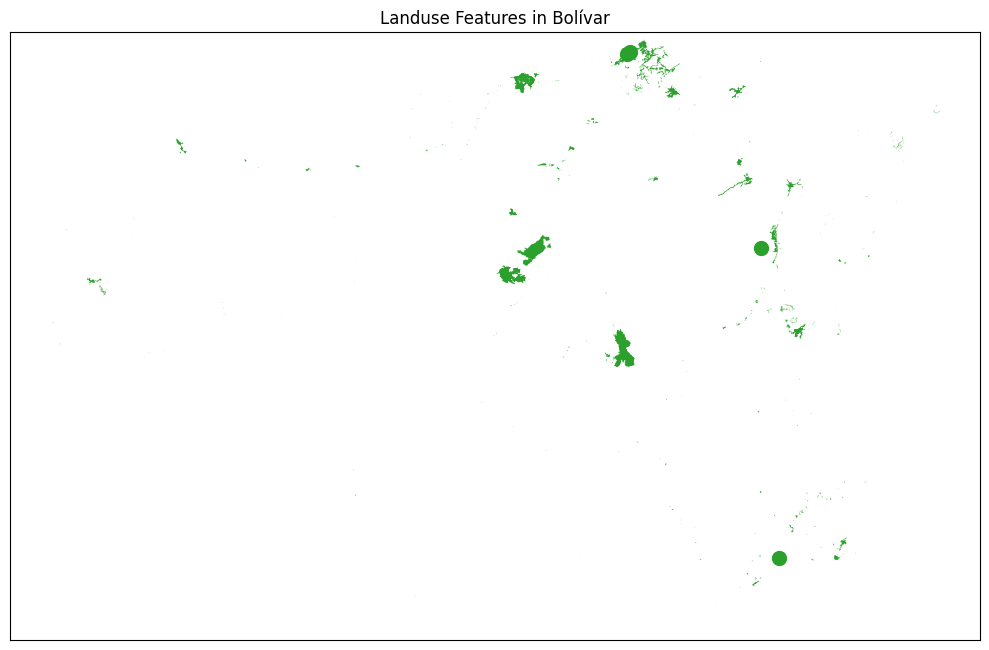

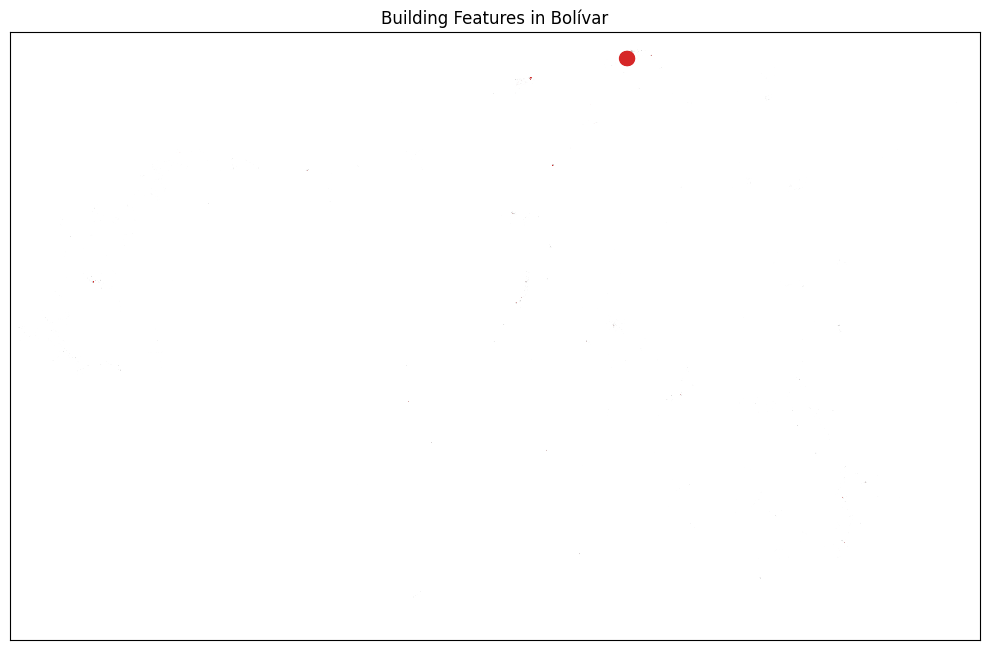

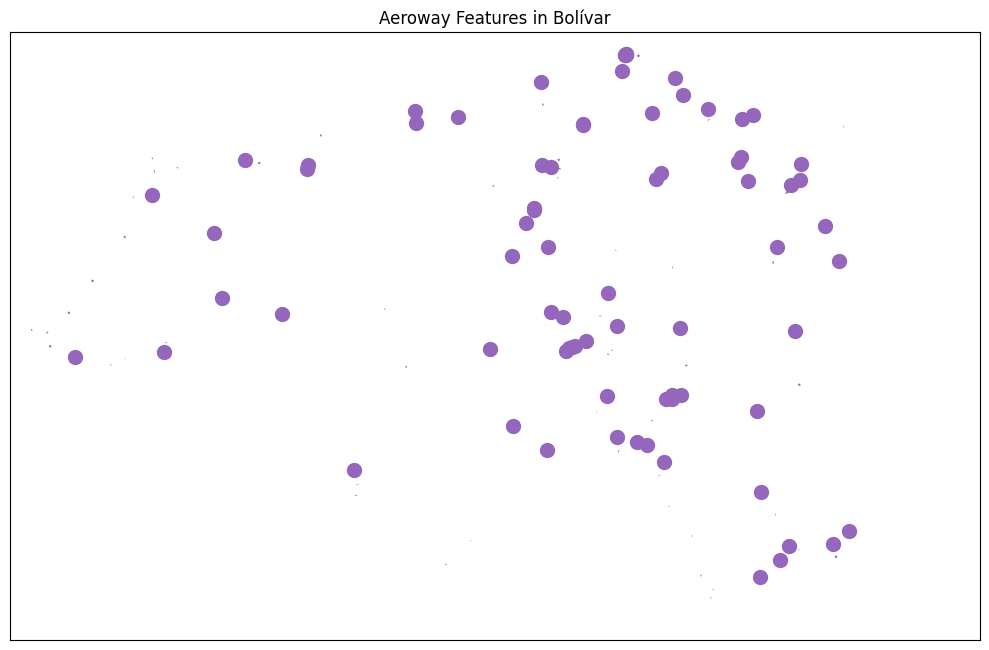

In [9]:
full_extent = osm_gdf.total_bounds  # [minx, miny, maxx, maxy]

for feature in feature_tags:
    if feature in osm_gdf.columns:
        fig, ax = plt.subplots(figsize=(10, 10))
        subset = osm_gdf[osm_gdf[feature].notnull()]
        subset.plot(ax=ax, color=color_map.get(feature, "gray"), markersize=100)

        ax.set_xlim(full_extent[0], full_extent[2])
        ax.set_ylim(full_extent[1], full_extent[3])
        ax.set_title(f"{feature.capitalize()} Features in Bolívar")

        # Hide ticks and tick labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.tick_params(left=False, bottom=False)

        plt.tight_layout()
        plt.show()